In [4]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.pal import probabilistic_al
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_blobs(random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

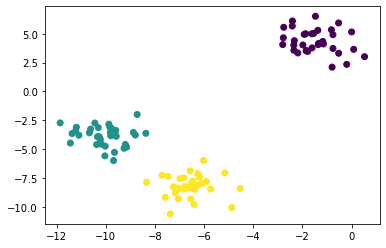

In [3]:
from matplotlib import pyplot as plt
plt.scatter(*X.T, c=y)
plt.show()

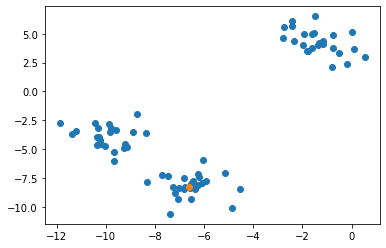

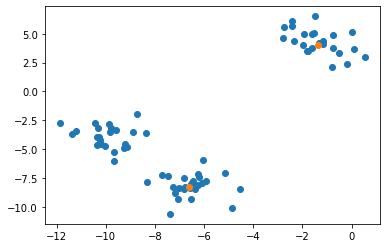

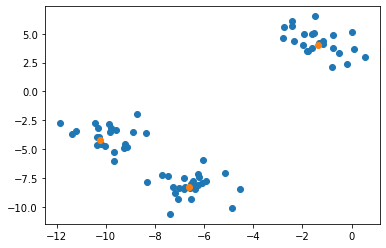

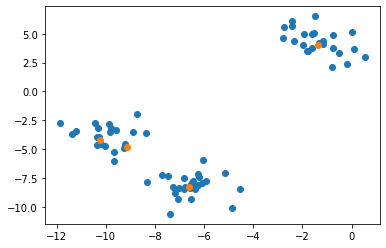

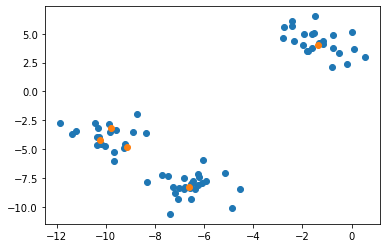

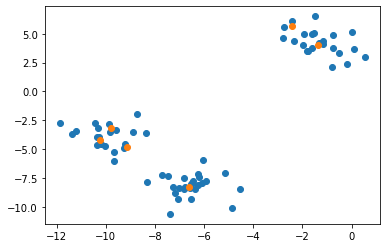

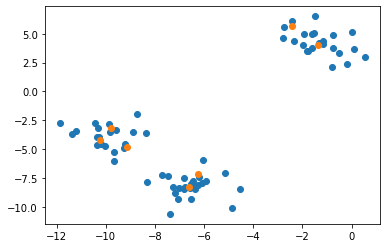

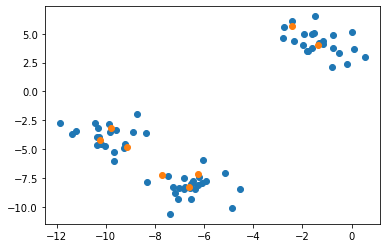

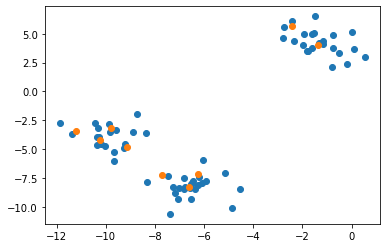

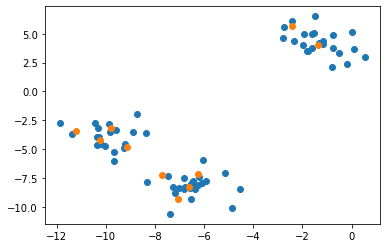

In [4]:
# initializing the learner
X_pool = X_train
y_pool = y_train

selection = lambda classifier, X: uncertainty_sampling(classifier, X, random_tie_break=False)
selection = probabilistic_al
selection = lambda classifier, X: probabilistic_al(classifier, X, prior=0.01)


learner = ActiveLearner(estimator=RandomForestClassifier(), query_strategy=selection)

# query for labels
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    X_labeled = learner.X_training
    plt.scatter(X_pool[:,0], X_pool[:,1])
    plt.scatter(X_labeled[:,0], X_labeled[:,1])
    plt.show()
#     print('Queried indices:', query_idx)

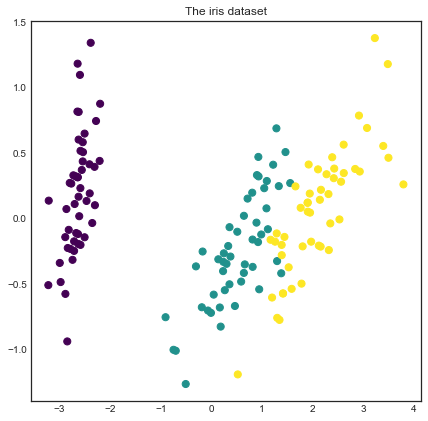

TypeError: object of type 'ActiveLearner' has no len()

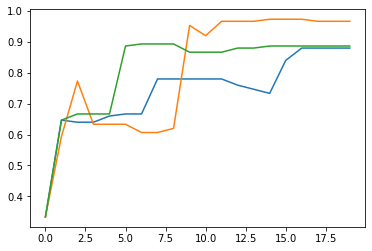

In [18]:
"""
In this example the use of ActiveLearner is demonstrated on the iris dataset in a pool-based sampling setting.
For more information on the iris dataset, see https://en.wikipedia.org/wiki/Iris_flower_data_set
For its scikit-learn interface, see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Import strategies
from modAL.uncertainty import uncertainty_sampling
from modAL.pal import probabilistic_al
from modAL.expected_error import expected_error_reduction
from modAL.disagreement import vote_entropy_sampling

# loading the iris dataset
iris = load_iris()
# visualizing the classes
with plt.style.context('seaborn-white'):
    pca = PCA(n_components=2).fit_transform(iris['data'])
    plt.figure(figsize=(7, 7))
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=iris['target'], cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()

# initial training data
train_idx = [0, 50, 100]
X_train = iris['data'][train_idx]
y_train = iris['target'][train_idx]

# generating the pool
X_pool = np.delete(iris['data'], train_idx, axis=0)
y_pool = np.delete(iris['target'], train_idx)

# initializing the active learner
uncer = lambda classifier, X: uncertainty_sampling(classifier, X, random_tie_break=False)
pal = lambda classifier, X: probabilistic_al(classifier, X, prior=0.01)

strategies = [(uncer, 'uncertainty sampling'), (pal, 'pal'), (expected_error_reduction, 'eer'),
              (vote_entropy_sampling, 'disagreement')]

for strategy, name in strategies:
    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors=3),
        X_training=X_train, y_training=y_train, query_strategy=strategy)

    # pool-based sampling
    n_queries = 20
    accuracy = []
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(X_pool)
        learner.teach(
            X=X_pool[query_idx].reshape(1, -1),
            y=y_pool[query_idx].reshape(1, )
        )
        # remove queried instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        accuracy.append(learner.score(iris['data'], iris['target']))
    plt.plot(accuracy, label=name)

# show learning curves
plt.legend()
plt.show()